<a href="https://colab.research.google.com/github/WeronikaRedlinska/ForexForecast/blob/main/ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd /content/drive/MyDrive/Magisterka2025/LSTM

/content/drive/MyDrive/Magisterka2025/LSTM


In [5]:
!pip install pmdarima==2.0.4

In [6]:
!pip install numpy==1.26.4


In [7]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from pmdarima import auto_arima, ARIMA, model_selection
import numpy as np
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
import math


In [71]:
df = pd.read_csv("/content/drive/MyDrive/Magisterka2025/LSTM/data/EURUSD=X.csv")
df = df.drop([0,1])
df = df.rename(columns={'Price':'Date'})
headers = ['Close','High','Low','Open']
for header in headers:
  df[header]=df[header].astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index("Date", inplace= True)

df['prev_close'] = df['Close'].shift(1)
df['Return']=(df['Close']/df['prev_close'] - 1)*100
df = df.iloc[1:]
df = df.loc[:, [ 'Return', 'Close', 'High', 'Low', 'Open', 'Volume', 'prev_close']]
df.head()

,Return,Close,High,Low,Open,Volume,prev_close
Date,,,,,,,
2021-01-04,0.578221,1.225070,1.230999,1.217137,1.224905,0,1.218027
2021-01-05,0.007356,1.225160,1.229483,1.224995,1.225295,0,1.225070
2021-01-06,0.397299,1.230027,1.235025,1.226693,1.229861,0,1.225160
2021-01-07,0.331976,1.234111,1.234568,1.224665,1.233776,0,1.230027
2021-01-08,-0.564484,1.227144,1.228215,1.221493,1.226873,0,1.234111


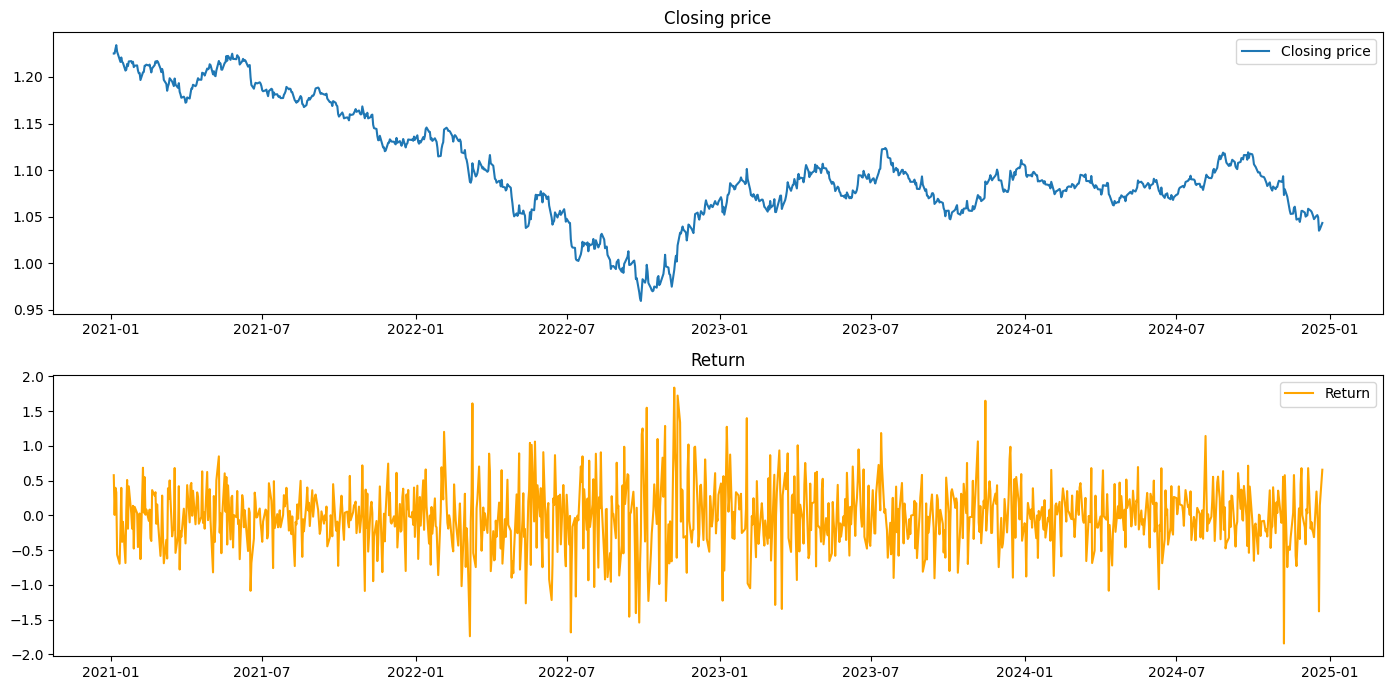

In [54]:
plt.figure(figsize=(14, 7))

# Subplot for the original series
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot
plt.plot(df.Close, label='Closing price')
plt.title('Closing price')
plt.legend()

# Subplot for the differenced series
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd subplot
plt.plot(df['Return'], label='Return', color='orange')
plt.title('Return')
plt.legend()

# Adjust layout to prevent overlapping of titles and labels
plt.tight_layout()
plt.show()

In [19]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['Close'].dropna())
print('p-value: %f' % result[1])

# Interpreting the results
if result[1] < 0.05:
    print("Evidence suggests that the time series is stationary.")
else:
    print("Evidence suggests that the time series is not stationary.")

p-value: 0.269422
Evidence suggests that the time series is not stationary.


In [20]:
result = adfuller(df['Return'].dropna())
print('p-value: %f' % result[1])

# Interpreting the results
if result[1] < 0.05:
    print("Evidence suggests that the time series is stationary.")
else:
    print("Evidence suggests that the time series is not stationary.")

p-value: 0.000000
Evidence suggests that the time series is stationary.


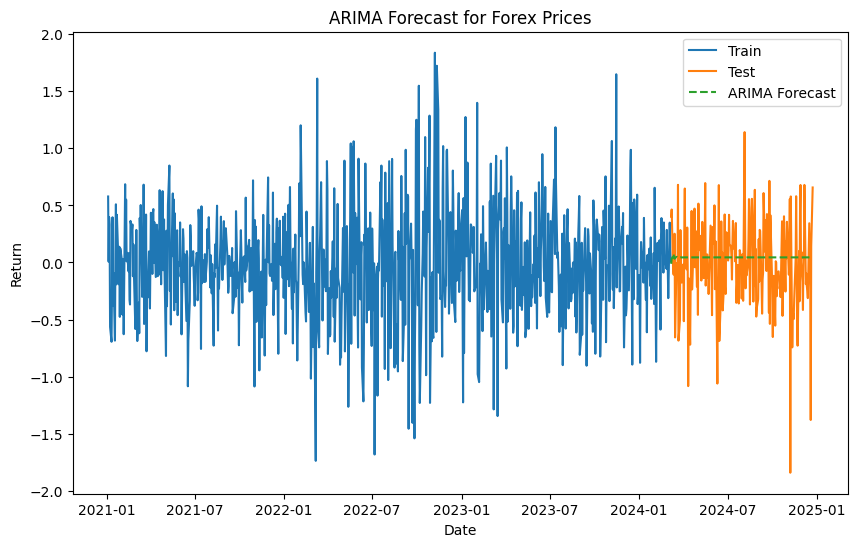

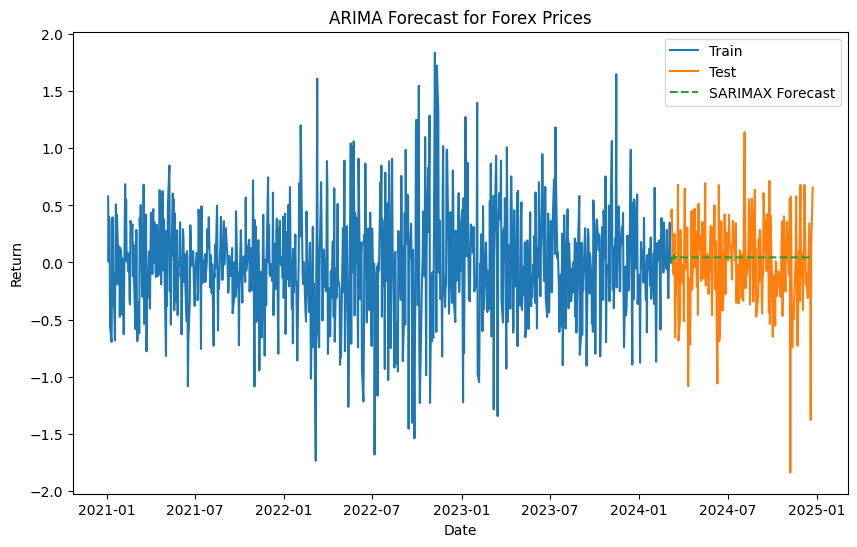

ARIMA RMSE: 0.3905
SARIMAX RMSE: 0.4019


In [35]:

df = pd.DataFrame(df, columns=['Return'])
train, test = train_test_split(df, test_size=0.2, shuffle=False)

arima_model = ARIMA(train, order=(5, 1, 0))
arima_fitted = arima_model.fit()

arima_forecast = arima_fitted.forecast(steps=len(test))

plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Return'], label='Train')
plt.plot(test.index, test['Return'], label='Test')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', linestyle='--')
plt.title('ARIMA Forecast for Forex Prices')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.show()

sarimax_model = SARIMAX(train,
                       order=(5, 1, 0),   # ARIMA parameters
                       seasonal_order=(0, 1, 1, 5),  # Seasonal parameters (P, D, Q, s)
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarimax_fitted = sarimax_model.fit()

sarimax_forecast = sarimax_fitted.forecast(steps=len(test))

plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Return'], label='Train')
plt.plot(test.index, test['Return'], label='Test')
plt.plot(test.index, arima_forecast, label='SARIMAX Forecast', linestyle='--')
plt.title('ARIMA Forecast for Forex Prices')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error
import math

arima_rmse = math.sqrt(mean_squared_error(test['Return'], arima_forecast))
sarimax_rmse = math.sqrt(mean_squared_error(test['Return'], sarimax_forecast))

print(f"ARIMA RMSE: {arima_rmse:.4f}")
print(f"SARIMAX RMSE: {sarimax_rmse:.4f}")

In [37]:
arima_forecast

,predicted_mean
2024-03-07,-0.011654
2024-03-08,0.032185
2024-03-11,0.056505
2024-03-12,0.075257
2024-03-13,0.039645
...,...
2024-12-17,0.044841
2024-12-18,0.044841
2024-12-19,0.044841
2024-12-20,0.044841


In [ ]:
df = pd.DataFrame(df, columns=['Return'])
train, test = train_test_split(df, test_size=0.2, shuffle=False)

arima_model = ARIMA(train, order=(5, 1, 0))
arima_fitted = arima_model.fit()

# Forecasting with ARIMA
arima_forecast = arima_fitted.forecast(steps=len(test))

# Plot ARIMA results
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Return'], label='Train')
plt.plot(test.index, test['Return'], label='Test')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', linestyle='--')
plt.title('ARIMA Forecast for Forex Prices')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.show()

sarimax_model = SARIMAX(train,
                       order=(5, 1, 0),   # ARIMA parameters
                       seasonal_order=(0, 1, 1, 5),  # Seasonal parameters (P, D, Q, s)
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarimax_fitted = sarimax_model.fit()

sarimax_forecast = sarimax_fitted.forecast(steps=len(test))

plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Return'], label='Train')
plt.plot(test.index, test['Return'], label='Test')
plt.plot(test.index, arima_forecast, label='SARIMAX Forecast', linestyle='--')
plt.title('ARIMA Forecast for Forex Prices')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error
import math

arima_rmse = math.sqrt(mean_squared_error(test['Return'], arima_forecast))
sarimax_rmse = math.sqrt(mean_squared_error(test['Return'], sarimax_forecast))

print(f"ARIMA RMSE: {arima_rmse:.4f}")
print(f"SARIMAX RMSE: {sarimax_rmse:.4f}")

ARIMA and SARIMAX on trend data


In [80]:
res = sm.tsa.seasonal_decompose(df.Return, model="additive")
df = res.trend
df = df.to_frame()
df = df.fillna(0)
df = df.rename(columns={'trend':'Return'})
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1036 entries, 2021-01-04 to 2024-12-23
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Return  1036 non-null   float64
dtypes: float64(1)
memory usage: 16.2 KB


In [81]:
auto_model = auto_arima(train['Return'], seasonal=False, trace=True)
auto_model.summary()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1075.283, Time=0.73 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-225.034, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1033.054, Time=0.06 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-715.797, Time=0.13 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-1051.026, Time=0.23 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-1068.241, Time=0.40 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-1082.032, Time=0.80 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-1075.114, Time=0.36 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,2)(0,0,0)[0]             : AIC=-1079.448, Time=1.01 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=0.88 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.82 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-1073.436, Time=0.56 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,3)(0,0,0)[0]             : AIC=inf, Time=1.06 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-1079.201, Time=1.26 sec

Best model:  ARIMA(3,0,2)(0,0,0)[0]          
Total fit time: 8.419 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  828
Model:               SARIMAX(3, 0, 2)   Log Likelihood                 547.016
Date:                Sat, 29 Mar 2025   AIC                          -1082.032
Time:                        21:07:38   BIC                          -1053.718
Sample:                    01-04-2021   HQIC                         -1071.173
                         - 03-06-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5371      0.088      6.138      0.000       0.366       0.709
ar.L2          0.6999      0.084      8.317      0.000       0.535       0.865
ar.L3         -0.5282      0.068     -7.807      0.000      -0.661      -0.396
ma.L1          0.3512      0.100      3.516      0.000       0.155       0.547
ma.L2         -0.3933      0.103     -3.829      0.000      -0.595      -0.192
sigma2         0.0156      0.001     25.525      0.000       0.014       0.017
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                76.11
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               1.52   Skew:                             0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

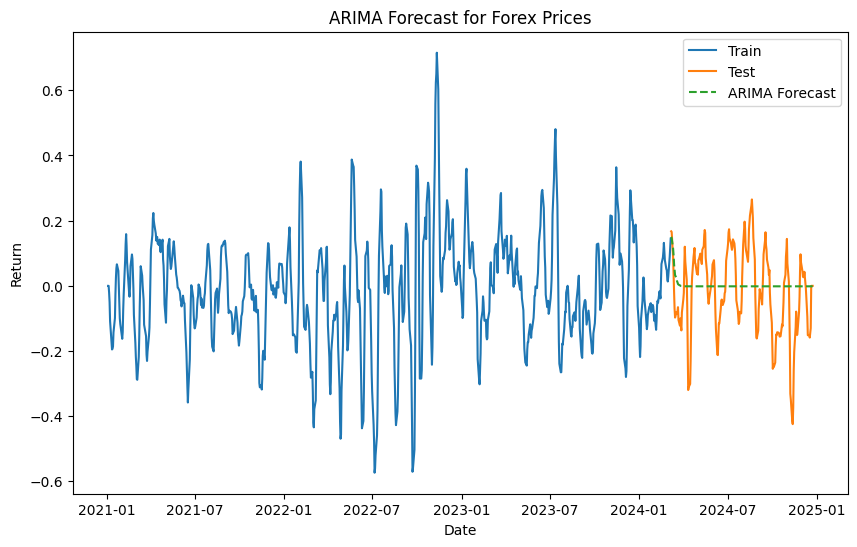

In [82]:
df = pd.DataFrame(df, columns=['Return'])
train, test = train_test_split(df, test_size=0.2, shuffle=False)

arima_model = ARIMA(train, order=(3, 0, 2))
arima_fitted = arima_model.fit()

arima_forecast = arima_fitted.forecast(steps=len(test))

plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Return'], label='Train')
plt.plot(test.index, test['Return'], label='Test')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', linestyle='--')
plt.title('ARIMA Forecast for Forex Prices')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.show()


In [86]:
arima_rmse = math.sqrt(mean_squared_error(test['Return'], arima_forecast))
print(f"ARIMA RMSE: {arima_rmse:.4f}")



ARIMA RMSE: 0.1329
